<h1 style="text-align: center;" markdown="3">Algorithm 5 - Support Vector Machine Classifier</h1> 


# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
[Data Setup](#setup)  
[Scikit-Learn Support Vector Machine Classifier](#sklearn-svm)  
&nbsp;&nbsp;&nbsp;[Include All Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Calibration with Platt Scaling](#calibration)  
[Summary](#summary)

# Support Vector Machine Classifier Introduction <a class="anchor" id="introduction"></a>
Support vector machines (SVM) can be used for discriminative supervised classification or regression. At their essence, SVMs perform binary classification by constructing an optimal hyperplane to separate the training data with as big a margin possible. New data are classified according to which side of the hyperplane they fall onto.

# Data setup <a class="anchor" id="setup"></a>

First, load in the standard libraries and inspect the training data. 

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add the local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'svm'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


# Scikit-Learn Support Vector Machine Model <a class="anchor" id="sklearn-svm"></a>


SVM can take a long time to run, especially on large datasets. Beause of this, we'll add a `SUBSAMPLE` variable to downsample the size of the dataset by default. To run these algorithms across all of the data, set `SUBSAMPLE = 1`. Results will not match the published results when the notebook only uses a portion of the training data.

In [3]:
# SUBSAMPLE = 0.1
SUBSAMPLE = 1

def subsample(X, y, w, stratify=True, seed=566):
    n_samples = int(SUBSAMPLE * X.shape[0])
    
    rng = np.random.RandomState(seed)
    
    if stratify:
        y_rate = y.mean()
        n_true = int(n_samples * y_rate)
        n_false = n_samples - n_true
        
        true_idx = rng.choice(np.where(y)[0], n_true, replace=False)
        false_idx = rng.choice(np.where(~y)[0], n_false, replace=False)
        
        sample_idx = np.union1d(true_idx, false_idx)
    else:
        sample_idx = rng.choice(np.arange(X.shape[0]), n_samples, replace=False)
    
    return X.iloc[sample_idx, :], y[sample_idx], w[sample_idx]

In [4]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


CPU times: user 5 s, sys: 136 ms, total: 5.14 s
Wall time: 5.14 s
CPU times: user 1.24 s, sys: 6.74 ms, total: 1.24 s
Wall time: 1.24 s
In-sample score: 77.24%


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


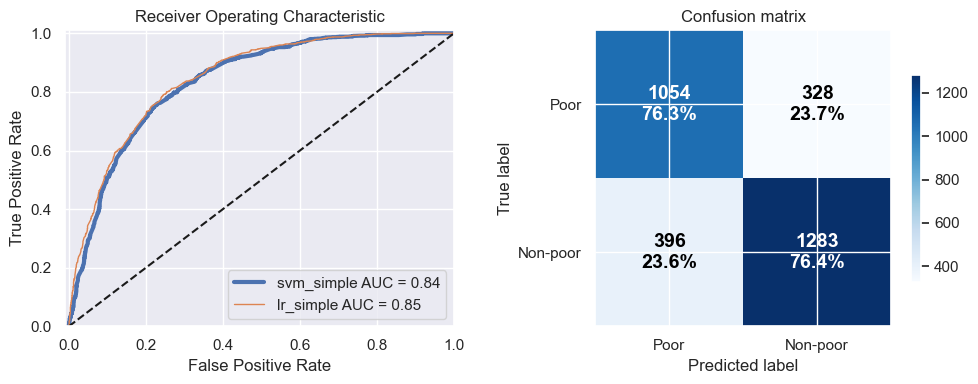

,svm_simple,lr_simple
accuracy,0.763476,0.766743
recall,0.762663,0.738784
precision,0.726897,0.743086
f1,0.744350,0.740929
cross_entropy,0.497498,0.478969
roc_auc,0.836655,0.847852
cohen_kappa,0.524525,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 59.80% 


In [5]:
# Support Vector Machines
from sklearn.svm import SVC

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# Fit the model
model = SVC(probability=True)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## SVC with all features <a class="anchor" id="all-feats"></a>

Now let's try using the full feature set

CPU times: user 51.8 s, sys: 262 ms, total: 52.1 s
Wall time: 52.1 s
CPU times: user 10.2 s, sys: 28 ms, total: 10.2 s
Wall time: 10.2 s
In-sample score: 93.15%


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


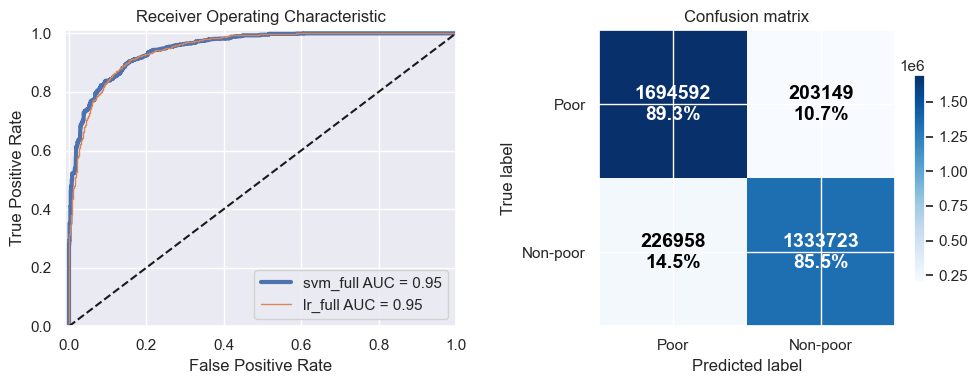

,svm_full,lr_full
accuracy,0.875635,0.874877
recall,0.892952,0.871201
precision,0.881888,0.854507
f1,0.887386,0.862773
cross_entropy,0.283143,0.288402
roc_auc,0.950414,0.948595
cohen_kappa,0.755589,0.747812


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.12% 


In [6]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# Fit the model
model = SVC(probability=True)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>

The SVC model has a single parameter, `C`, we can attempt to tune. This determines the regularization strength. We can also see how different kernels perform. 

NOTE: This cell may take up to an hour to run.

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ...........C=0.0001, kernel=linear;, score=0.818 total time= 1.3min
[CV 3/3] END ..............C=0.0001, kernel=rbf;, score=0.549 total time= 1.6min
[CV 2/3] END ..............C=0.0001, kernel=rbf;, score=0.549 total time= 1.6min
[CV 1/3] END ..............C=0.0001, kernel=rbf;, score=0.549 total time= 1.6min
[CV 2/3] END ...........C=0.0001, kernel=linear;, score=0.813 total time= 1.3min
[CV 1/3] END .C=0.03162277660168379, kernel=rbf;, score=0.850 total time= 1.2min
[CV 2/3] END .C=0.03162277660168379, kernel=rbf;, score=0.845 total time= 1.2min
[CV 3/3] END ...........C=0.0001, kernel=linear;, score=0.833 total time= 1.3min
[CV 1/3] END C=0.03162277660168379, kernel=linear;, score=0.862 total time=  32.6s
[CV 2/3] END C=0.03162277660168379, kernel=linear;, score=0.873 total time=  33.4s
[CV 3/3] END C=0.03162277660168379, kernel=linear;, score=0.880 total time=  34.8s
[CV 3/3] END .C=0.03162277660168379, kernel

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


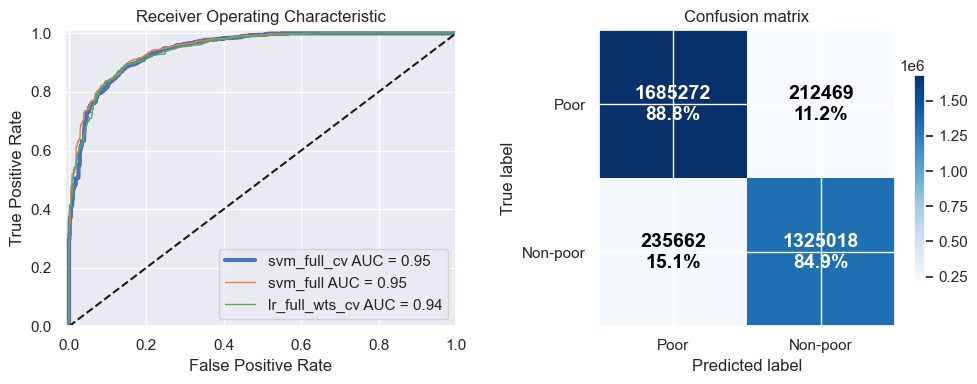

,svm_full_cv,svm_full,lr_full_wts_cv
accuracy,0.870423,0.875635,0.873458
recall,0.888041,0.892952,0.891581
precision,0.877319,0.881888,0.879470
f1,0.882647,0.887386,0.885484
cross_entropy,0.295494,0.283143,0.300510
roc_auc,0.945324,0.950414,0.944482
cohen_kappa,0.749740,0.755589,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.55% 


In [7]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# build the model
estimator = SVC(probability=True)
parameters = {'C': 10**np.linspace(-4,1,3), 
              'kernel': ['rbf', 'linear']}
model = GridSearchCV(estimator, parameters, cv=3, verbose=3, n_jobs=4)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['svm_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)
best_model = model

# Classifier Calibration with Isotonic Regression <a class="anchor" id="calibration"></a>


CPU times: user 2min 21s, sys: 916 ms, total: 2min 21s
Wall time: 2min 22s
CPU times: user 23.8 s, sys: 232 ms, total: 24 s
Wall time: 24.4 s
In-sample score: 89.33%


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


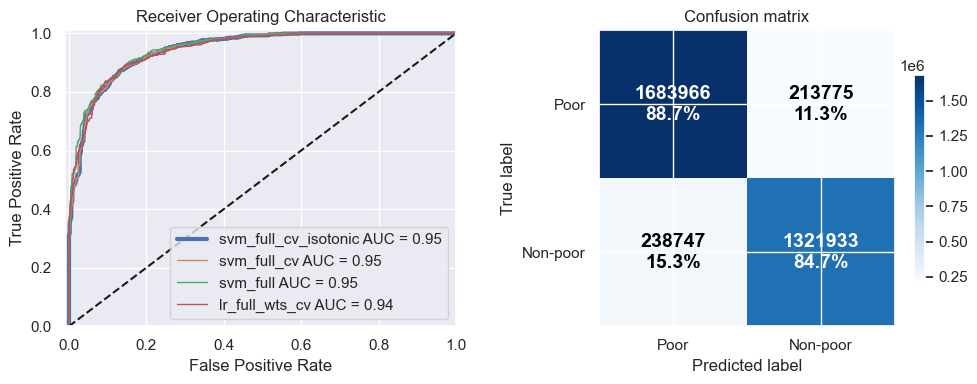

,svm_full_cv_isotonic,svm_full_cv,svm_full,lr_full_wts_cv
accuracy,0.869153,0.870423,0.875635,0.873458
recall,0.887353,0.888041,0.892952,0.891581
precision,0.875828,0.877319,0.881888,0.879470
f1,0.881553,0.882647,0.887386,0.885484
cross_entropy,0.295549,0.295494,0.283143,0.300510
roc_auc,0.945131,0.945324,0.950414,0.944482
cohen_kappa,0.749900,0.749740,0.755589,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.82% 


In [8]:
from sklearn.calibration import CalibratedClassifierCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# Calibrate the model
model = CalibratedClassifierCV(best_model.best_estimator_, method='isotonic')
%time model.fit(X_train, y_train)
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['svm_full_cv',
                                                    'svm_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_cv_isotonic', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

# SVM Malawi Summary <a class="anchor" id="summary"></a>



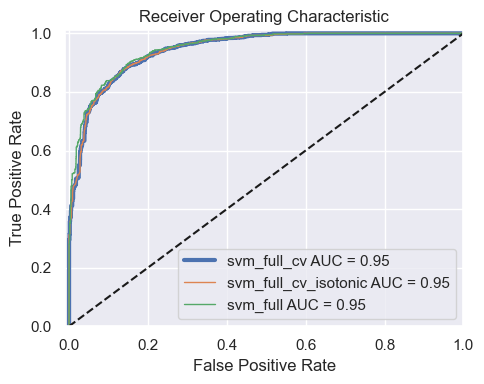

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
svm_full_cv,0.870423,0.888041,0.877319,0.882647,0.295494,0.945324,0.749740,0.014472
svm_full_cv_isotonic,0.869153,0.887353,0.875828,0.881553,0.295549,0.945131,0.749900,0.017138
svm_full,0.875635,0.892952,0.881888,0.887386,0.283143,0.950414,0.755589,0.010087


In [9]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)